In [1]:
from importlib import reload
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers

In [98]:
# import modules
import src.models
reload(src.models)
from src.models import *

import src.dataMethods
reload(src.dataMethods)
from src.dataMethods import *

import src.features as features
reload(features)

<module 'src.features' from 'C:\\Users\\Andrew\\Documents\\CeR\\GestRec\\leap_gesture_rec\\src\\features.py'>

In [42]:
gestures, g2idx, idx2g = get_gestures(version=0)

In [116]:
a = 'data/loopsV0/Andrew_3loopV0.csv'
a2 = 'data/loopsV3/shapes2loops.csv'
b = 'recordings/derived_test.csv'
n_frames = 40
X, y = CSV2examples(raw_file=a2, g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, dicts_gen=True)
X_val, y_val = CSV2examples(raw_file='data/loopsV3/shapes_test.csv', g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, dicts_gen=False)
print(X.shape)

mean fps: 28.79
target fps: 30
taking every 1 frames
99.92% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True


C:\Users\Andrew\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


dealt with 0 of 10680 rows with nans
mean fps: 28.80
target fps: 30
taking every 1 frames
99.48% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 2692 rows with nans
(500, 40, 48)


In [ ]:
X, y = folder2examples('data/train/', target_fps=25, g2idx=g2idx)

In [117]:
model = many2one_model(n_features = X.shape[-1], n_frames=X.shape[1], n_gestures=len(g2idx), n_layers=1, rnn_units=5, recurrent_dropout=0.2, bidirectional=True)

Model: "many2one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 40, 48)]          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 10)                2160      
_________________________________________________________________
dense_13 (Dense)             (None, 9)                 99        
Total params: 2,259
Trainable params: 2,259
Non-trainable params: 0
_________________________________________________________________


In [118]:
# note: using hs 30, recurrent dropout 0.5, bidirectional, and not including features added on the 3/02 or getting rid of VoI_drop features, got high 80s percentage accuracy on val
# maybe it was 25fps?
# with the new features, can get 89% val accuracy with 35 frame long examples. 25 is too short.
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, validation_data=(X_val, y_val), epochs=100, batch_size = 50)

Train on 500 samples, validate on 120 samples
Epoch 1/100
500/500 [==============================] - 3s 7ms/sample - loss: 2.1115 - accuracy: 0.1520 - val_loss: 2.0070 - val_accuracy: 0.3417
Epoch 2/100
500/500 [==============================] - 0s 556us/sample - loss: 1.9287 - accuracy: 0.2940 - val_loss: 1.8602 - val_accuracy: 0.4750
Epoch 3/100
500/500 [==============================] - 0s 509us/sample - loss: 1.7793 - accuracy: 0.4720 - val_loss: 1.7437 - val_accuracy: 0.5417
Epoch 4/100
500/500 [==============================] - 0s 495us/sample - loss: 1.6605 - accuracy: 0.6060 - val_loss: 1.6495 - val_accuracy: 0.6167
Epoch 5/100
500/500 [==============================] - 0s 501us/sample - loss: 1.5541 - accuracy: 0.6780 - val_loss: 1.5669 - val_accuracy: 0.6500
Epoch 6/100
500/500 [==============================] - 0s 505us/sample - loss: 1.4764 - accuracy: 0.7000 - val_loss: 1.4921 - val_accuracy: 0.6750
Epoch 7/100
500/500 [==============================] - 0s 580us/sample - l

In [112]:
model.save('models/V0/35f_30hs.h5')

In [39]:
model = tf.keras.models.load_model('models/V2/25f_32hs_15c_2.h5')

In [41]:
# load test data
X_test, y_test = CSV2examples('data/recordings/test_loop.csv', g2idx=g2idx, n_frames=50)

mean fps: 115.19
target fps: 25
skipping every 5 frames
Found left hand data:  False
Found right hand data:  True
dropped 0 of 2777 rows with nans


In [50]:
# predict on a random test case
i = np.random.randint(0, len(X_test))
print(i)
pred = model.predict(np.expand_dims(np.array(X_test[i]), axis=0))
print(pred)
print('Predicted: ', idx2g[np.argmax(pred)])
print('Truth: ', idx2g[y_test[i]])

33
[[0.95594496 0.04405507]]
Predicted:  no_gesture
Truth:  fist


In [54]:
print(idx2g[y[1]])

so_so


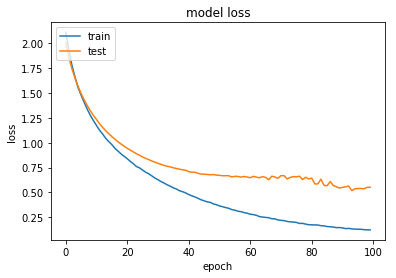

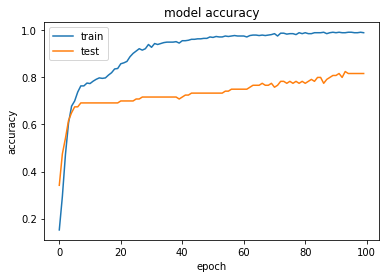

In [119]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

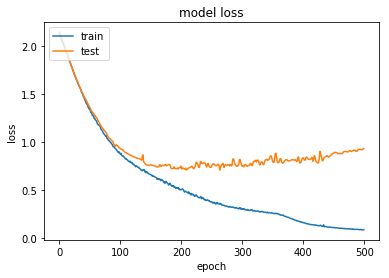

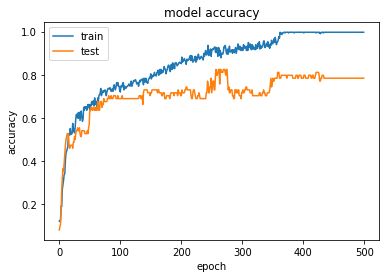

In [51]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

In [ ]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

In [120]:
# get confusion matrix
pred = np.argmax(model.predict(X_val), axis=-1)
pred_gest = [idx2g[i] for i in pred]
y_gest = [idx2g[i] for i in y_val]
pd.crosstab([y_gest], [pred_gest], rownames=['Actual'], colnames=['Predicted'])

Predicted,love_heart_set,no_gesture,round_drawn,round_set,small,square_drawn,this_big,triangle_drawn,triangle_set
Actual,,,,,,,,,
love_heart_set,12,0,1,0,0,0,0,0,0
no_gesture,0,15,0,0,0,0,0,0,1
round_drawn,0,0,13,0,0,0,0,0,0
round_set,0,0,0,13,0,0,0,0,0
small,0,4,0,0,9,0,0,0,0
square_drawn,0,0,8,0,0,1,0,4,0
this_big,0,0,0,0,0,0,13,0,0
triangle_drawn,0,0,4,0,0,0,0,9,0
triangle_set,0,0,0,0,0,0,0,0,13


In [100]:
Xa = [[[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[1,1],[1,2],[1,3],[1,4],[1,5],[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[4,1],[4,2]]]
ya = [0,0,0,0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,3,3,4,4]
xb, yb = X_y2examples(Xa, ya, n_frames=4)
print(xb)
print(yb)

[[[0 1]
  [0 2]
  [0 3]
  [0 4]]

 [[0 3]
  [0 4]
  [0 5]
  [0 6]]

 [[0 5]
  [0 6]
  [0 7]
  [0 8]]

 [[1 1]
  [1 2]
  [1 3]
  [1 4]]

 [[3 1]
  [3 2]
  [3 3]
  [3 4]]

 [[3 3]
  [3 4]
  [3 5]
  [3 6]]]
[0 0 0 1 3 3]


In [94]:
Xa[0:2]

[[0, 1], [0, 2]]